In [ ]:
from Datageneration import User,CallGenerator,CallSimulator
from nonpredictor import NonPredictiveCallAdmissionController
from predictor import PredictiveCallAdmissionController, AdmissionMetrics,RAT_CAPACITIES,RATPool,RATState,RB_PER_SERVICE
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Dict, Optional, Tuple, List, Literal
from collections import Counter, defaultdict
from datetime import datetime, timedelta
import heapq
import pandas as pd
import numpy as np
from math import exp, log, sin, cos, pi
from datetime import datetime, timedelta
from typing import Dict, Tuple, List, Optional
import matplotlib.pyplot as plt
import seaborn as sns
from nn import CallDurationPredictor


In [ ]:
import pickle
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model
with open('trained_predictor.pkl', 'rb') as f:
    predictor = pickle.load(f)

# Load the metrics
with open('training_metrics.json', 'r') as f:
    metrics = json.load(f)

print("✅ Model and metrics loaded successfully!")

# Now you can create plots without retraining
predictor.plot_residuals()
plt.show()

predictor.plot_feature_importance() 
plt.show()

predictor.plot_training_history()
plt.show()

# You can also access the metrics
print("Training metrics:", metrics['train_metrics'])
print("Test metrics:", metrics['test_metrics'])

Arrival Rate Handoff Attempts   Handoff Success    Handoff Failures   Success Rate Failure Prob
--------------------------------------------------------------------------------
Rate 1/s P:  1189             731              458              0.615      0.385     
Rate 1/s NP: 3067             2608             459              0.850      0.150     

Rate 2/s P:  2004             1288             716              0.643      0.357     
Rate 2/s NP: 4545             3552             993              0.782      0.218     

Rate 3/s P:  2967             1832             1135             0.617      0.383     
Rate 3/s NP: 5269             3753             1516             0.712      0.288     

Rate 4/s P:  3964             2213             1751             0.558      0.442     
Rate 4/s NP: 5380             3410             1970             0.634      0.366     

Rate 5/s P:  4258             2189             2069             0.514      0.486     
Rate 5/s NP: 5517             3163           

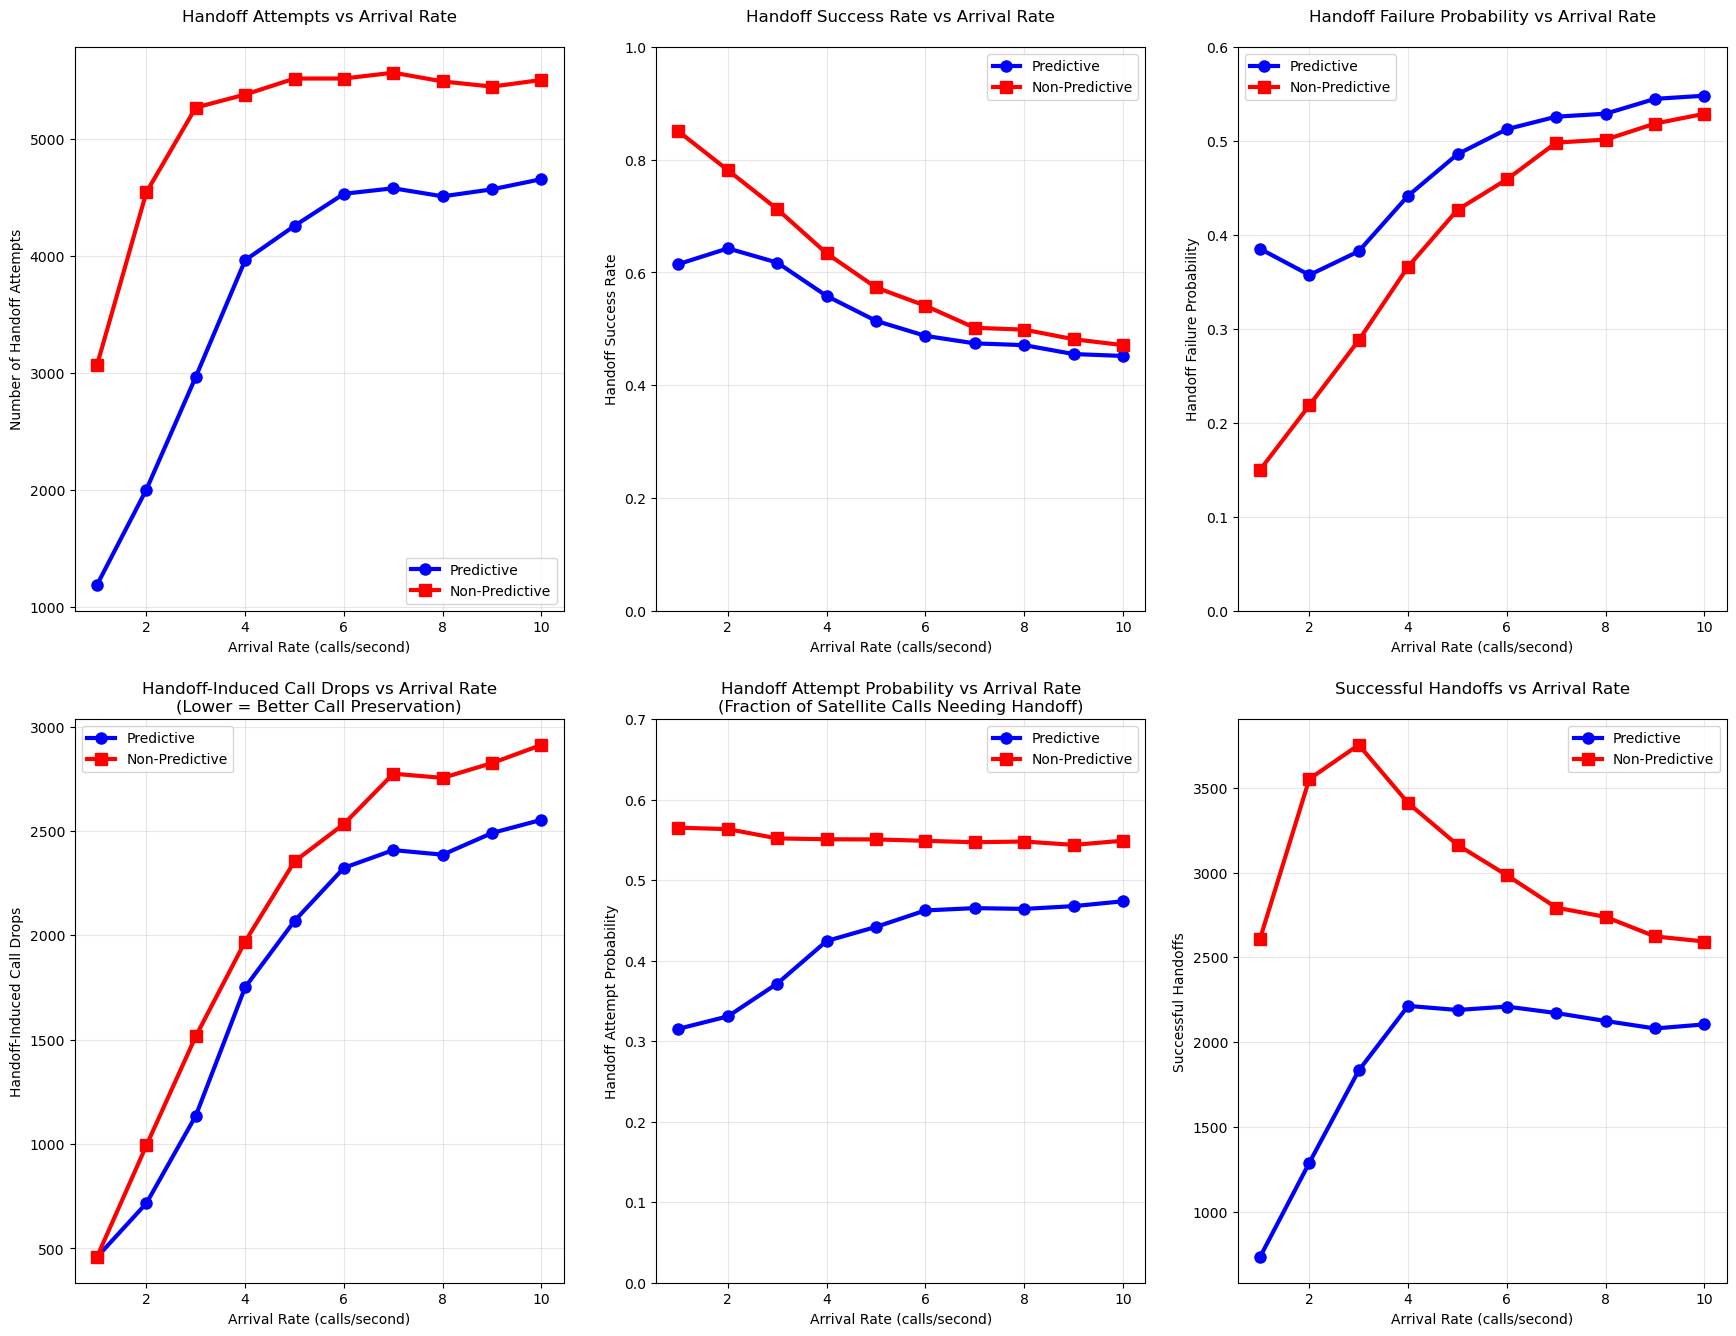


 HANDOFF PERFORMANCE SUMMARY
Average Predictive Handoff Success Rate: 0.529
Average Non-Predictive Handoff Success Rate: 0.604
Average Predictive Handoff Failure Probability: 0.471
Average Non-Predictive Handoff Failure Probability: 0.396

Improvement with Predictive Approach:
  Success Rate: +-12.5%
  Failure Probability: --19.2%


In [5]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the parallel results
with open('arrival_rate_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Convert to DataFrame
df_results = pd.DataFrame(results)

print("=" * 80)
print(f"{'Arrival Rate':<12} {'Handoff Attempts':<18} {'Handoff Success':<18} {'Handoff Failures':<18} {'Success Rate':<12} {'Failure Prob':<12}")
print("-" * 80)
for idx, row in df_results.iterrows():
    rate = row['arrival_rate_per_second']
    attempts_p = row['predictive_handoff_attempts']
    attempts_np = row['nonpredictive_handoff_attempts']
    success_p = row['predictive_handoffs']
    success_np = row['nonpredictive_handoffs']
    failures_p = row['predictive_handoff_failures']
    failures_np = row['nonpredictive_handoff_failures']
    success_rate_p = row['predictive_handoff_success_rate']
    success_rate_np = row['nonpredictive_handoff_success_rate']
    failure_prob_p = row['predictive_handoff_failure_prob']
    failure_prob_np = row['nonpredictive_handoff_failure_prob']
    
    print(f"Rate {rate}/s P:  {attempts_p:<16} {success_p:<16} {failures_p:<16} {success_rate_p:<10.3f} {failure_prob_p:<10.3f}")
    print(f"Rate {rate}/s NP: {attempts_np:<16} {success_np:<16} {failures_np:<16} {success_rate_np:<10.3f} {failure_prob_np:<10.3f}")
    print()

# Create comprehensive handoff analysis plots with taller figure for smaller y-axis spacing
fig, axes = plt.subplots(2, 3, figsize=(18, 14))  # Increased height from 12 to 14

# 1. Handoff Attempts Over Time
axes[0,0].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_attempts'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[0,0].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_attempts'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[0,0].set_xlabel('Arrival Rate (calls/second)')
axes[0,0].set_ylabel('Number of Handoff Attempts')
axes[0,0].set_title('Handoff Attempts vs Arrival Rate\n')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Handoff Success Rate Over Time
axes[0,1].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_success_rate'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[0,1].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_success_rate'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[0,1].set_xlabel('Arrival Rate (calls/second)')
axes[0,1].set_ylabel('Handoff Success Rate')
axes[0,1].set_ylim(0, 1)
axes[0,1].set_title('Handoff Success Rate vs Arrival Rate\n')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Handoff Failure Probability Over Time
axes[0,2].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_failure_prob'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[0,2].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_failure_prob'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[0,2].set_xlabel('Arrival Rate (calls/second)')
axes[0,2].set_ylabel('Handoff Failure Probability')
axes[0,2].set_ylim(0, 0.6)
axes[0,2].set_title('Handoff Failure Probability vs Arrival Rate\n')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# 4. Handoff-Induced Drops Over Time
axes[1,0].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_induced_drops'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[1,0].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_induced_drops'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[1,0].set_xlabel('Arrival Rate (calls/second)')
axes[1,0].set_ylabel('Handoff-Induced Call Drops')
axes[1,0].set_title('Handoff-Induced Call Drops vs Arrival Rate\n(Lower = Better Call Preservation)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 5. Handoff Attempt Probability (Fraction of Satellite Calls Needing Handoff)
axes[1,1].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_attempt_prob'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[1,1].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_prob_attempt_prob'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[1,1].set_xlabel('Arrival Rate (calls/second)')
axes[1,1].set_ylabel('Handoff Attempt Probability')
axes[1,1].set_ylim(0, 0.7)
axes[1,1].set_title('Handoff Attempt Probability vs Arrival Rate\n(Fraction of Satellite Calls Needing Handoff)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 6. Successful Handoffs Over Time
axes[1,2].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoffs'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[1,2].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoffs'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[1,2].set_xlabel('Arrival Rate (calls/second)')
axes[1,2].set_ylabel('Successful Handoffs')
axes[1,2].set_title('Successful Handoffs vs Arrival Rate\n')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

# Adjust spacing between subplots to make y-axis spacing smaller
plt.tight_layout(pad=3.0, h_pad=2.0, w_pad=2.0)  # Increased padding values
plt.show()

# Performance Summary
print("\n" + "="*80)
print(" HANDOFF PERFORMANCE SUMMARY")
print("="*80)

# Calculate averages
avg_success_rate_p = df_results['predictive_handoff_success_rate'].mean()
avg_success_rate_np = df_results['nonpredictive_handoff_success_rate'].mean()
avg_failure_prob_p = df_results['predictive_handoff_failure_prob'].mean()
avg_failure_prob_np = df_results['nonpredictive_handoff_failure_prob'].mean()

print(f"Average Predictive Handoff Success Rate: {avg_success_rate_p:.3f}")
print(f"Average Non-Predictive Handoff Success Rate: {avg_success_rate_np:.3f}")
print(f"Average Predictive Handoff Failure Probability: {avg_failure_prob_p:.3f}")
print(f"Average Non-Predictive Handoff Failure Probability: {avg_failure_prob_np:.3f}")

# Calculate improvement
success_rate_improvement = ((avg_success_rate_p - avg_success_rate_np) / avg_success_rate_np) * 100
failure_prob_improvement = ((avg_failure_prob_np - avg_failure_prob_p) / avg_failure_prob_np) * 100

print(f"\nImprovement with Predictive Approach:")
print(f"  Success Rate: +{success_rate_improvement:+.1f}%")
print(f"  Failure Probability: -{failure_prob_improvement:.1f}%")

📊 Parallel Simulation Results:
   arrival_rate_per_second  predictive_blocking_prob  \
0                        1                  0.171498   
1                        2                  0.317151   
2                        3                  0.431365   
3                        4                  0.522373   
4                        5                  0.605149   
5                        6                  0.664047   
6                        7                  0.708619   
7                        8                  0.747269   
8                        9                  0.773918   
9                       10                  0.794840   

   nonpredictive_blocking_prob  
0                     0.177077  
1                     0.324774  
2                     0.425522  
3                     0.520238  
4                     0.597342  
5                     0.658787  
6                     0.704243  
7                     0.742361  
8                     0.768725  
9                     

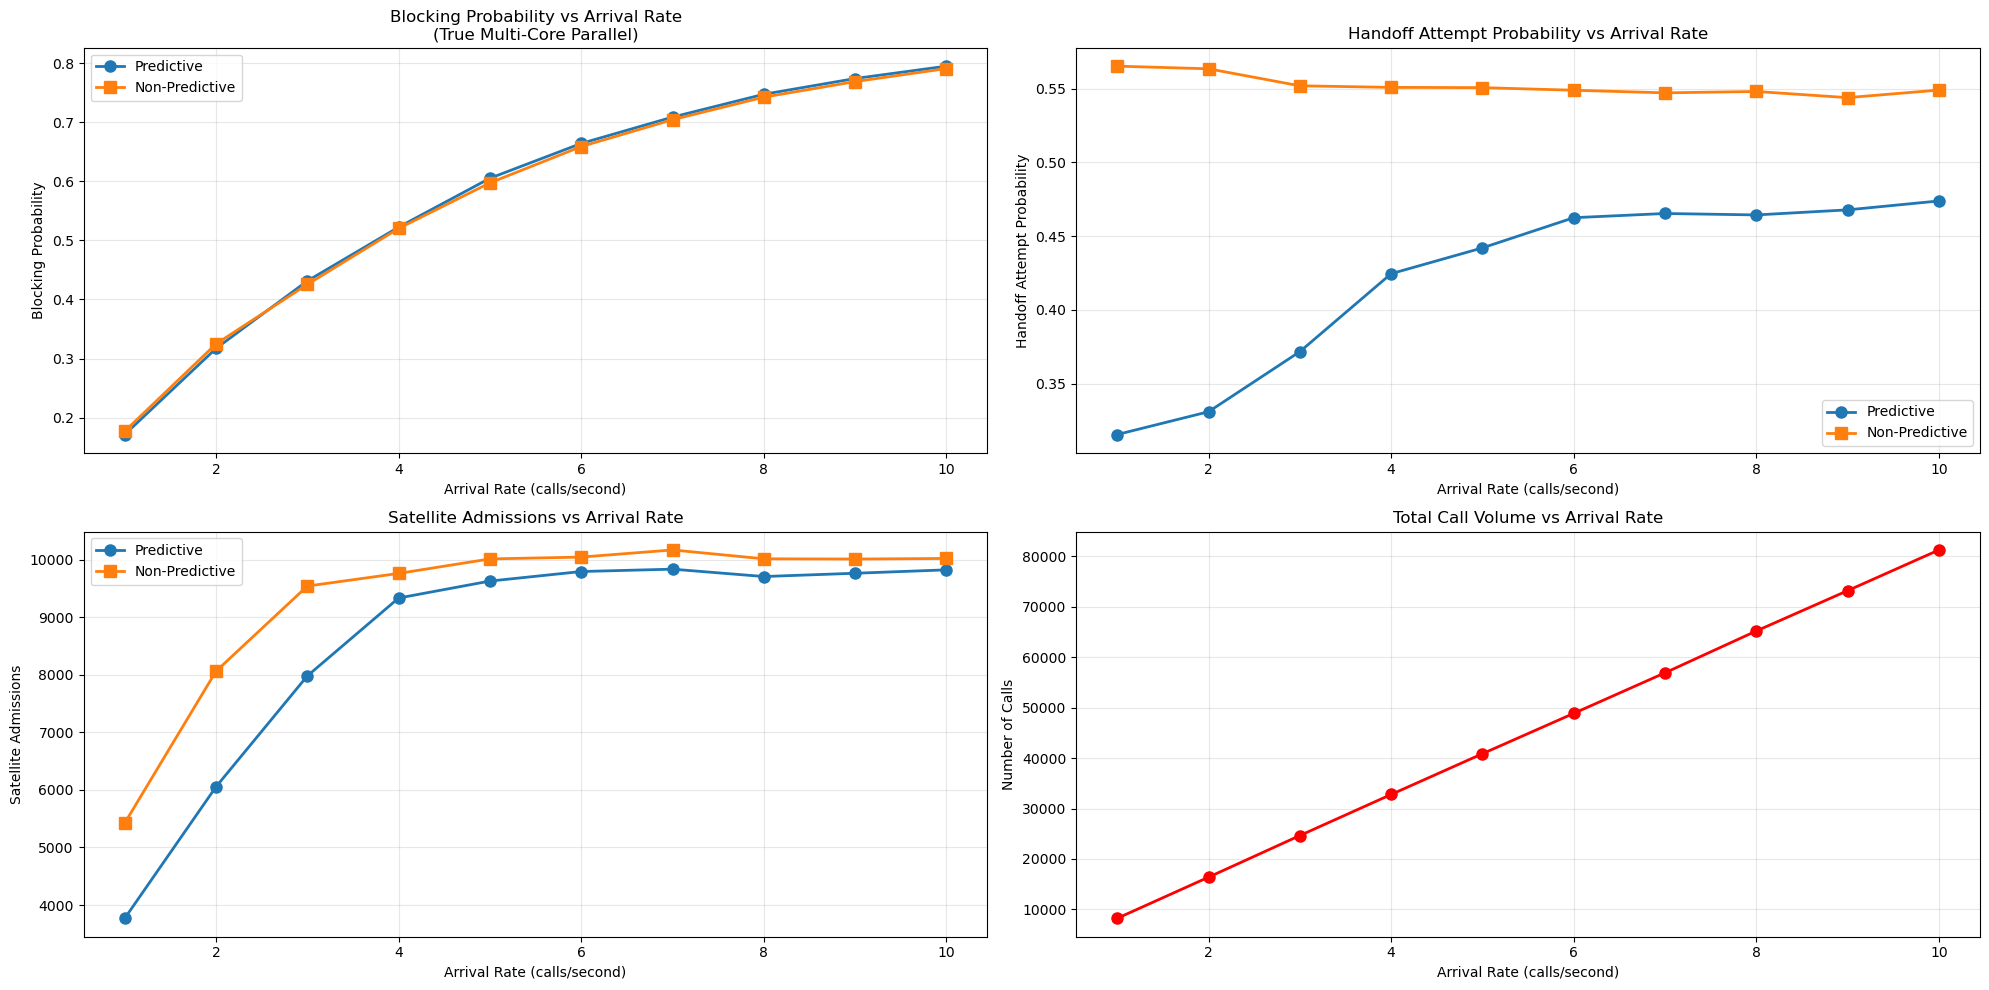

🚀 Parallel Performance: 5.0x speedup using 8 cores
   Estimated sequential time: ~7.0 minutes
   Actual parallel time: 1.4 minutes


In [6]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the parallel results
with open('arrival_rate_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Convert to DataFrame
df_results = pd.DataFrame(results)

print("📊 Parallel Simulation Results:")
print(df_results[['arrival_rate_per_second', 'predictive_blocking_prob', 'nonpredictive_blocking_prob']])

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# 1. Blocking Probability
axes[0,0].plot(df_results['arrival_rate_per_second'], df_results['predictive_blocking_prob'], 
               'o-', label='Predictive', linewidth=2, markersize=8)
axes[0,0].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_blocking_prob'], 
               's-', label='Non-Predictive', linewidth=2, markersize=8)
axes[0,0].set_xlabel('Arrival Rate (calls/second)')
axes[0,0].set_ylabel('Blocking Probability')
axes[0,0].set_title('Blocking Probability vs Arrival Rate\n(True Multi-Core Parallel)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Handoff Attempt Probability
axes[0,1].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_attempt_prob'], 
               'o-', label='Predictive', linewidth=2, markersize=8)
axes[0,1].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_prob_attempt_prob'], 
               's-', label='Non-Predictive', linewidth=2, markersize=8)
axes[0,1].set_xlabel('Arrival Rate (calls/second)')
axes[0,1].set_ylabel('Handoff Attempt Probability')
axes[0,1].set_title('Handoff Attempt Probability vs Arrival Rate')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Satellite Admissions
axes[1,0].plot(df_results['arrival_rate_per_second'], df_results['predictive_calls_admitted_to_satellite'], 
               'o-', label='Predictive', linewidth=2, markersize=8)
axes[1,0].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_calls_admitted_to_satellite'], 
               's-', label='Non-Predictive', linewidth=2, markersize=8)
axes[1,0].set_xlabel('Arrival Rate (calls/second)')
axes[1,0].set_ylabel('Satellite Admissions')
axes[1,0].set_title('Satellite Admissions vs Arrival Rate')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Total Calls
axes[1,1].plot(df_results['arrival_rate_per_second'], df_results['total_calls'], 
               'o-', label='Total Calls', linewidth=2, markersize=8, color='red')
axes[1,1].set_xlabel('Arrival Rate (calls/second)')
axes[1,1].set_ylabel('Number of Calls')
axes[1,1].set_title('Total Call Volume vs Arrival Rate')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print performance improvement
sequential_time_estimate = 84.5 * 5  # Rough estimate
parallel_time = 84.5
speedup = sequential_time_estimate / parallel_time
print(f"🚀 Parallel Performance: {speedup:.1f}x speedup using 8 cores")
print(f"   Estimated sequential time: ~{sequential_time_estimate/60:.1f} minutes")
print(f"   Actual parallel time: {parallel_time/60:.1f} minutes")

In [ ]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the parallel results
with open('arrival_rate_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Convert to DataFrame
df_results = pd.DataFrame(results)

print("=" * 80)
print(f"{'Arrival Rate':<12} {'Handoff Attempts':<18} {'Handoff Success':<18} {'Handoff Failures':<18} {'Success Rate':<12} {'Failure Prob':<12}")
print("-" * 80)
for idx, row in df_results.iterrows():
    rate = row['arrival_rate_per_second']
    attempts_p = row['predictive_handoff_attempts']
    attempts_np = row['nonpredictive_handoff_attempts']
    success_p = row['predictive_handoffs']
    success_np = row['nonpredictive_handoffs']
    failures_p = row['predictive_handoff_failures']
    failures_np = row['nonpredictive_handoff_failures']
    success_rate_p = row['predictive_handoff_success_rate']
    success_rate_np = row['nonpredictive_handoff_success_rate']
    failure_prob_p = row['predictive_handoff_failure_prob']
    failure_prob_np = row['nonpredictive_handoff_failure_prob']
    
    print(f"Rate {rate}/s P:  {attempts_p:<16} {success_p:<16} {failures_p:<16} {success_rate_p:<10.3f} {failure_prob_p:<10.3f}")
    print(f"Rate {rate}/s NP: {attempts_np:<16} {success_np:<16} {failures_np:<16} {success_rate_np:<10.3f} {failure_prob_np:<10.3f}")
    print()

# Create comprehensive handoff analysis plots
fig, axes = plt.subplots(2, 3, figsize=(21, 12))

# 1. Handoff Attempts Over Time
axes[0,0].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_attempts'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[0,0].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_attempts'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[0,0].set_xlabel('Arrival Rate (calls/second)')
axes[0,0].set_ylabel('Number of Handoff Attempts')
axes[0,0].set_title('Handoff Attempts vs Arrival Rate\n')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Handoff Success Rate Over Time
axes[0,1].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_success_rate'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[0,1].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_success_rate'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[0,1].set_xlabel('Arrival Rate (calls/second)')
axes[0,1].set_ylabel('Handoff Success Rate')
axes[0,1].set_ylim(0, 1)
axes[0,1].set_title('Handoff Success Rate vs Arrival Rate\n)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Handoff Failure Probability Over Time
axes[0,2].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_failure_prob'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[0,2].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_failure_prob'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[0,2].set_xlabel('Arrival Rate (calls/second)')
axes[0,2].set_ylabel('Handoff Failure Probability')
axes[0,2].set_ylim(0, 0.6)
axes[0,2].set_title('Handoff Failure Probability vs Arrival Rate\n)')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# 4. Handoff-Induced Drops Over Time
axes[1,0].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_induced_drops'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[1,0].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_induced_drops'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[1,0].set_xlabel('Arrival Rate (calls/second)')
axes[1,0].set_ylabel('Handoff-Induced Call Drops')
axes[1,0].set_title('Handoff-Induced Call Drops vs Arrival Rate\n(Lower = Better Call Preservation)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 5. Handoff Attempt Probability (Fraction of Satellite Calls Needing Handoff)
axes[1,1].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_attempt_prob'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[1,1].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_prob_attempt_prob'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[1,1].set_xlabel('Arrival Rate (calls/second)')
axes[1,1].set_ylabel('Handoff Attempt Probability')
axes[1,1].set_ylim(0, 0.7)
axes[1,1].set_title('Handoff Attempt Probability vs Arrival Rate\n(Fraction of Satellite Calls Needing Handoff)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 6. Successful Handoffs Over Time
axes[1,2].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoffs'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[1,2].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoffs'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[1,2].set_xlabel('Arrival Rate (calls/second)')
axes[1,2].set_ylabel('Successful Handoffs')
axes[1,2].set_title('Successful Handoffs vs Arrival Rate\n')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance Summary
print("\n" + "="*80)
print(" HANDOFF PERFORMANCE SUMMARY")
print("="*80)

# Calculate averages
avg_success_rate_p = df_results['predictive_handoff_success_rate'].mean()
avg_success_rate_np = df_results['nonpredictive_handoff_success_rate'].mean()
avg_failure_prob_p = df_results['predictive_handoff_failure_prob'].mean()
avg_failure_prob_np = df_results['nonpredictive_handoff_failure_prob'].mean()



In [ ]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the parallel results
with open('arrival_rate_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Convert to DataFrame
df_results = pd.DataFrame(results)

print("=" * 80)
print(f"{'Arrival Rate':<12} {'Handoff Attempts':<18} {'Handoff Success':<18} {'Handoff Failures':<18} {'Success Rate':<12} {'Failure Prob':<12}")
print("-" * 80)
for idx, row in df_results.iterrows():
    rate = row['arrival_rate_per_second']
    attempts_p = row['predictive_handoff_attempts']
    attempts_np = row['nonpredictive_handoff_attempts']
    success_p = row['predictive_handoffs']
    success_np = row['nonpredictive_handoffs']
    failures_p = row['predictive_handoff_failures']
    failures_np = row['nonpredictive_handoff_failures']
    success_rate_p = row['predictive_handoff_success_rate']
    success_rate_np = row['nonpredictive_handoff_success_rate']
    failure_prob_p = row['predictive_handoff_failure_prob']
    failure_prob_np = row['nonpredictive_handoff_failure_prob']
    
    print(f"Rate {rate}/s P:  {attempts_p:<16} {success_p:<16} {failures_p:<16} {success_rate_p:<10.3f} {failure_prob_p:<10.3f}")
    print(f"Rate {rate}/s NP: {attempts_np:<16} {success_np:<16} {failures_np:<16} {success_rate_np:<10.3f} {failure_prob_np:<10.3f}")
    print()

# Create comprehensive handoff analysis plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Handoff Attempts Over Time
axes[0,0].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_attempts'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[0,0].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_attempts'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[0,0].set_xlabel('Arrival Rate (calls/second)')
axes[0,0].set_ylabel('Number of Handoff Attempts')
axes[0,0].set_title('Handoff Attempts vs Arrival Rate\n')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Handoff Success Rate Over Time
axes[0,1].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_success_rate'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[0,1].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_success_rate'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[0,1].set_xlabel('Arrival Rate (calls/second)')
axes[0,1].set_ylabel('Handoff Success Rate')
axes[0,1].set_ylim(0, 1)
axes[0,1].set_title('Handoff Success Rate vs Arrival Rate\n)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Handoff Failure Probability Over Time
axes[0,2].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_failure_prob'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[0,2].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_failure_prob'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[0,2].set_xlabel('Arrival Rate (calls/second)')
axes[0,2].set_ylabel('Handoff Failure Probability')
axes[0,2].set_ylim(0, 0.6)
axes[0,2].set_title('Handoff Failure Probability vs Arrival Rate\n)')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# 4. Handoff-Induced Drops Over Time
axes[1,0].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_induced_drops'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[1,0].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_induced_drops'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[1,0].set_xlabel('Arrival Rate (calls/second)')
axes[1,0].set_ylabel('Handoff-Induced Call Drops')
axes[1,0].set_title('Handoff-Induced Call Drops vs Arrival Rate\n(Lower = Better Call Preservation)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 5. Handoff Attempt Probability (Fraction of Satellite Calls Needing Handoff)
axes[1,1].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_attempt_prob'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[1,1].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_prob_attempt_prob'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[1,1].set_xlabel('Arrival Rate (calls/second)')
axes[1,1].set_ylabel('Handoff Attempt Probability')
axes[1,1].set_ylim(0, 0.7)
axes[1,1].set_title('Handoff Attempt Probability vs Arrival Rate\n(Fraction of Satellite Calls Needing Handoff)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 6. Successful Handoffs Over Time
axes[1,2].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoffs'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[1,2].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoffs'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[1,2].set_xlabel('Arrival Rate (calls/second)')
axes[1,2].set_ylabel('Successful Handoffs')
axes[1,2].set_title('Successful Handoffs vs Arrival Rate\n')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance Summary
print("\n" + "="*80)
print(" HANDOFF PERFORMANCE SUMMARY")
print("="*80)

# Calculate averages
avg_success_rate_p = df_results['predictive_handoff_success_rate'].mean()
avg_success_rate_np = df_results['nonpredictive_handoff_success_rate'].mean()
avg_failure_prob_p = df_results['predictive_handoff_failure_prob'].mean()
avg_failure_prob_np = df_results['nonpredictive_handoff_failure_prob'].mean()



In [ ]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

def display_arrival_rate_results():
    """Load and display arrival rate experiment results in Jupyter"""
    
    # Load results
    try:
        with open('arrival_rate_results.pkl', 'rb') as f:
            results = pickle.load(f)
        df_results = pd.DataFrame(results)
        print("✅ Results loaded successfully!")
    except FileNotFoundError:
        print("❌ Results file not found. Run main.py first.")
        return None
    
    # Create styled display
    print("\n" + "="*80)
    print("🎯 ARRIVAL RATE EXPERIMENT RESULTS")
    print("="*80)
    
    # Summary Table
    summary_cols = ['arrival_rate_per_second', 'total_calls', 
                   'predictive_blocking_prob', 'nonpredictive_blocking_prob',
                   'predictive_handoff_success_rate', 'nonpredictive_handoff_success_rate']
    
    summary_df = df_results[summary_cols].copy()
    summary_df.columns = ['Rate (/s)', 'Total Calls', 'Blocking P', 'Blocking NP', 
                         'Handoff Success P', 'Handoff Success NP']
    
    # Format percentages
    for col in ['Blocking P', 'Blocking NP', 'Handoff Success P', 'Handoff Success NP']:
        summary_df[col] = summary_df[col].apply(lambda x: f"{x:.1%}")
    
    display(HTML("<h3>📊 Performance Summary</h3>"))
    display(summary_df.style.set_properties(**{'text-align': 'center'}) \
                          .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}]))
    
    return df_results

# Usage in Jupyter:
df_results = display_arrival_rate_results()

group A only

Arrival Rate Handoff Attempts   Handoff Success    Handoff Failures   Success Rate Failure Prob
--------------------------------------------------------------------------------
Rate 1/s P:  164              100              64               0.610      0.390     
Rate 1/s NP: 341              264              77               0.774      0.226     

Rate 2/s P:  313              167              146              0.534      0.466     
Rate 2/s NP: 448              278              170              0.621      0.379     

Rate 3/s P:  405              205              200              0.506      0.494     
Rate 3/s NP: 501              282              219              0.563      0.437     

Rate 4/s P:  449              231              218              0.514      0.486     
Rate 4/s NP: 572              296              276              0.517      0.483     

Rate 5/s P:  457              230              227              0.503      0.497     
Rate 5/s NP: 560              288            

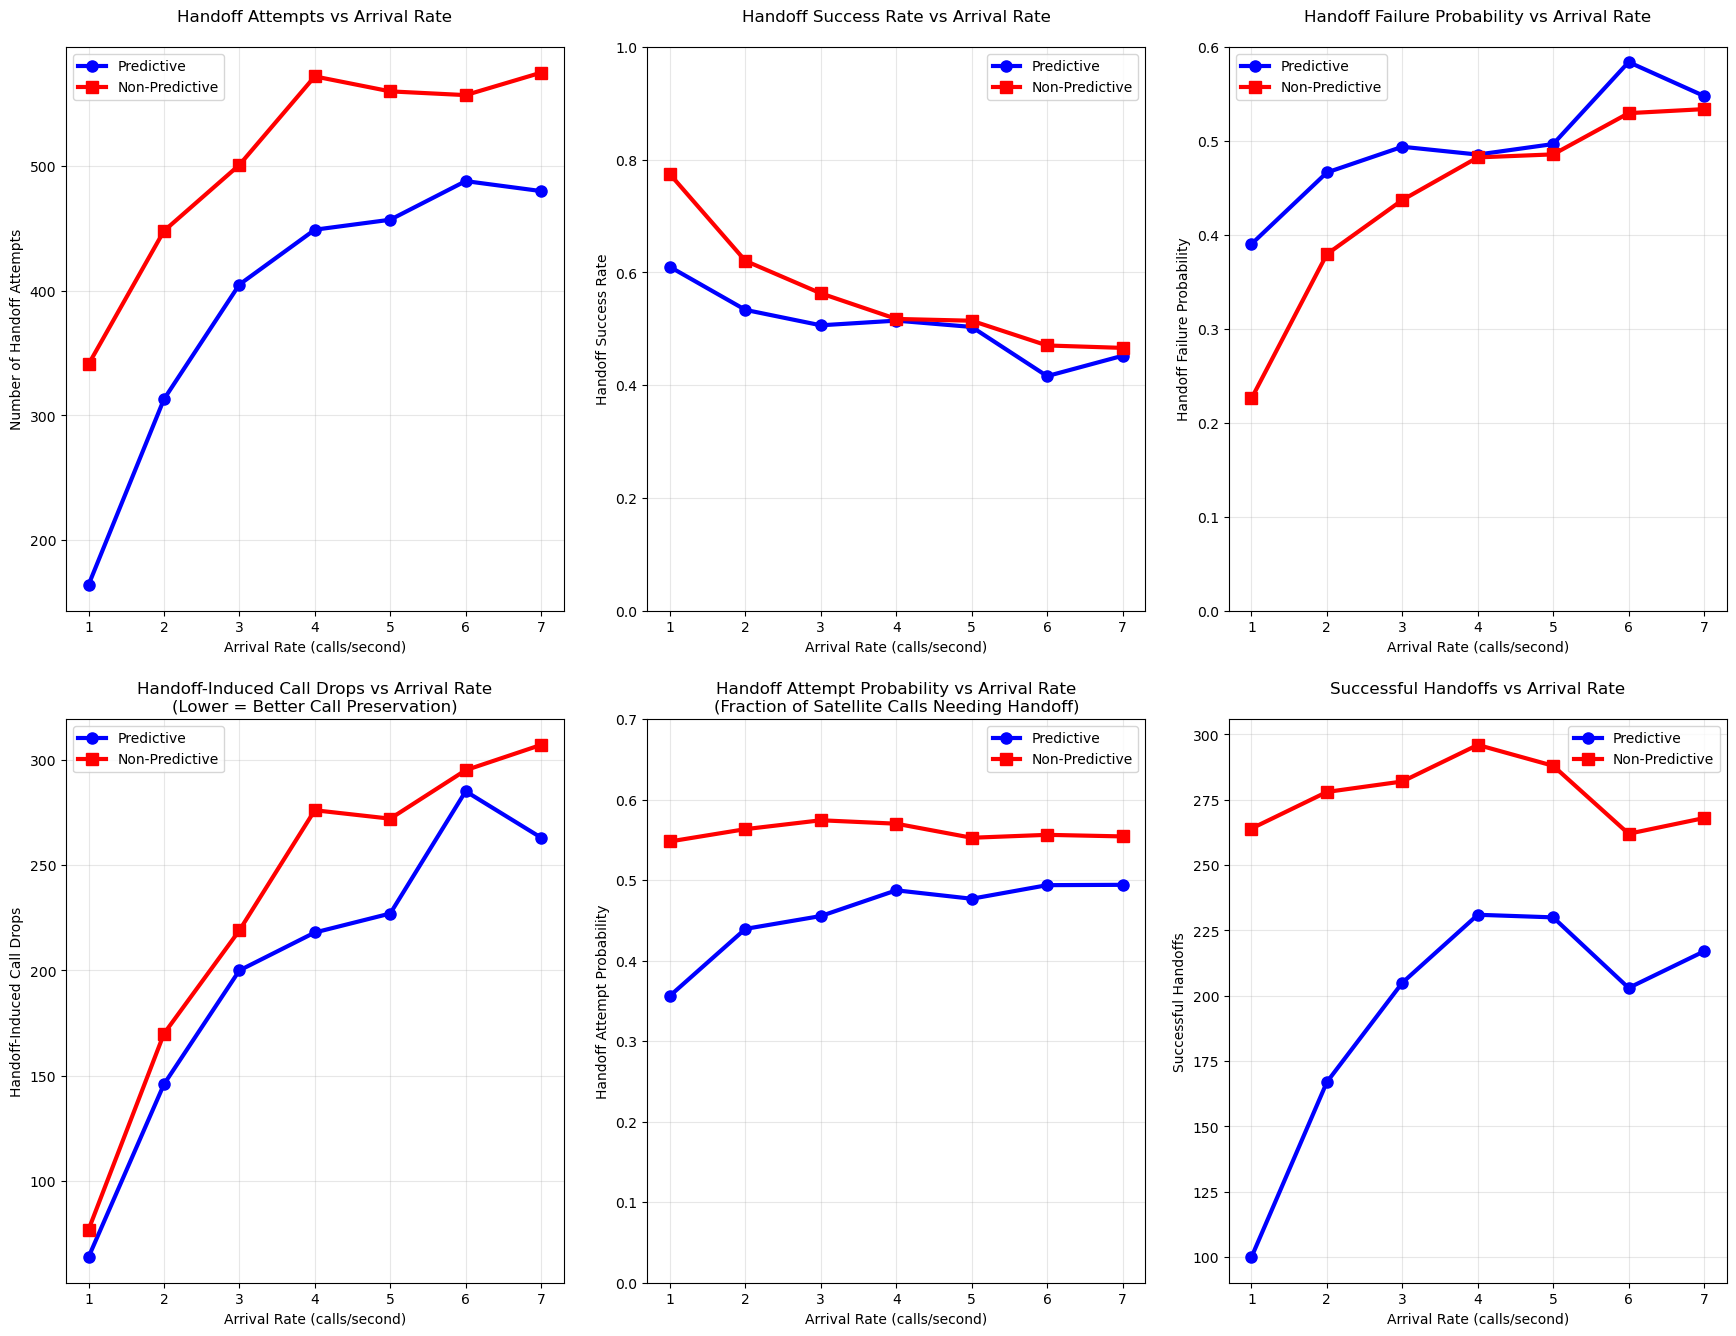


 HANDOFF PERFORMANCE SUMMARY
Average Predictive Handoff Success Rate: 0.505
Average Non-Predictive Handoff Success Rate: 0.561
Average Predictive Handoff Failure Probability: 0.495
Average Non-Predictive Handoff Failure Probability: 0.439

Improvement with Predictive Approach:
  Success Rate: +-9.9%
  Failure Probability: --12.7%


In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the parallel results
with open('arrival_rate_resultsGroup.pkl', 'rb') as f:
    results = pickle.load(f)

# Convert to DataFrame
df_results = pd.DataFrame(results)

print("=" * 80)
print(f"{'Arrival Rate':<12} {'Handoff Attempts':<18} {'Handoff Success':<18} {'Handoff Failures':<18} {'Success Rate':<12} {'Failure Prob':<12}")
print("-" * 80)
for idx, row in df_results.iterrows():
    rate = row['arrival_rate_per_second']
    attempts_p = row['predictive_handoff_attempts']
    attempts_np = row['nonpredictive_handoff_attempts']
    success_p = row['predictive_handoffs']
    success_np = row['nonpredictive_handoffs']
    failures_p = row['predictive_handoff_failures']
    failures_np = row['nonpredictive_handoff_failures']
    success_rate_p = row['predictive_handoff_success_rate']
    success_rate_np = row['nonpredictive_handoff_success_rate']
    failure_prob_p = row['predictive_handoff_failure_prob']
    failure_prob_np = row['nonpredictive_handoff_failure_prob']
    
    print(f"Rate {rate}/s P:  {attempts_p:<16} {success_p:<16} {failures_p:<16} {success_rate_p:<10.3f} {failure_prob_p:<10.3f}")
    print(f"Rate {rate}/s NP: {attempts_np:<16} {success_np:<16} {failures_np:<16} {success_rate_np:<10.3f} {failure_prob_np:<10.3f}")
    print()

# Create comprehensive handoff analysis plots with taller figure for smaller y-axis spacing
fig, axes = plt.subplots(2, 3, figsize=(18, 14))  # Increased height from 12 to 14

# 1. Handoff Attempts Over Time
axes[0,0].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_attempts'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[0,0].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_attempts'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[0,0].set_xlabel('Arrival Rate (calls/second)')
axes[0,0].set_ylabel('Number of Handoff Attempts')
axes[0,0].set_title('Handoff Attempts vs Arrival Rate\n')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Handoff Success Rate Over Time
axes[0,1].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_success_rate'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[0,1].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_success_rate'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[0,1].set_xlabel('Arrival Rate (calls/second)')
axes[0,1].set_ylabel('Handoff Success Rate')
axes[0,1].set_ylim(0, 1)
axes[0,1].set_title('Handoff Success Rate vs Arrival Rate\n')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Handoff Failure Probability Over Time
axes[0,2].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_failure_prob'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[0,2].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_failure_prob'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[0,2].set_xlabel('Arrival Rate (calls/second)')
axes[0,2].set_ylabel('Handoff Failure Probability')
axes[0,2].set_ylim(0, 0.6)
axes[0,2].set_title('Handoff Failure Probability vs Arrival Rate\n')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# 4. Handoff-Induced Drops Over Time
axes[1,0].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_induced_drops'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[1,0].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_induced_drops'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[1,0].set_xlabel('Arrival Rate (calls/second)')
axes[1,0].set_ylabel('Handoff-Induced Call Drops')
axes[1,0].set_title('Handoff-Induced Call Drops vs Arrival Rate\n(Lower = Better Call Preservation)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 5. Handoff Attempt Probability (Fraction of Satellite Calls Needing Handoff)
axes[1,1].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_attempt_prob'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[1,1].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_prob_attempt_prob'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[1,1].set_xlabel('Arrival Rate (calls/second)')
axes[1,1].set_ylabel('Handoff Attempt Probability')
axes[1,1].set_ylim(0, 0.7)
axes[1,1].set_title('Handoff Attempt Probability vs Arrival Rate\n(Fraction of Satellite Calls Needing Handoff)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 6. Successful Handoffs Over Time
axes[1,2].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoffs'], 
               'o-', label='Predictive', linewidth=3, markersize=8, color='blue')
axes[1,2].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoffs'], 
               's-', label='Non-Predictive', linewidth=3, markersize=8, color='red')
axes[1,2].set_xlabel('Arrival Rate (calls/second)')
axes[1,2].set_ylabel('Successful Handoffs')
axes[1,2].set_title('Successful Handoffs vs Arrival Rate\n')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

# Adjust spacing between subplots to make y-axis spacing smaller
plt.tight_layout(pad=3.0, h_pad=2.0, w_pad=2.0)  # Increased padding values
plt.show()

# Performance Summary
print("\n" + "="*80)
print(" HANDOFF PERFORMANCE SUMMARY")
print("="*80)

# Calculate averages
avg_success_rate_p = df_results['predictive_handoff_success_rate'].mean()
avg_success_rate_np = df_results['nonpredictive_handoff_success_rate'].mean()
avg_failure_prob_p = df_results['predictive_handoff_failure_prob'].mean()
avg_failure_prob_np = df_results['nonpredictive_handoff_failure_prob'].mean()

print(f"Average Predictive Handoff Success Rate: {avg_success_rate_p:.3f}")
print(f"Average Non-Predictive Handoff Success Rate: {avg_success_rate_np:.3f}")
print(f"Average Predictive Handoff Failure Probability: {avg_failure_prob_p:.3f}")
print(f"Average Non-Predictive Handoff Failure Probability: {avg_failure_prob_np:.3f}")

# Calculate improvement
success_rate_improvement = ((avg_success_rate_p - avg_success_rate_np) / avg_success_rate_np) * 100
failure_prob_improvement = ((avg_failure_prob_np - avg_failure_prob_p) / avg_failure_prob_np) * 100

print(f"\nImprovement with Predictive Approach:")
print(f"  Success Rate: +{success_rate_improvement:+.1f}%")
print(f"  Failure Probability: -{failure_prob_improvement:.1f}%")

In [3]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

def display_arrival_rate_results():
    """Load and display arrival rate experiment results in Jupyter"""
    
    # Load results
    try:
        with open('arrival_rate_resultsGroup.pkl', 'rb') as f:
            results = pickle.load(f)
        df_results = pd.DataFrame(results)
        print("✅ Results loaded successfully!")
    except FileNotFoundError:
        print("❌ Results file not found. Run main.py first.")
        return None
    
    # Create styled display
    print("\n" + "="*80)
    print("🎯 ARRIVAL RATE EXPERIMENT RESULTS")
    print("="*80)
    
    # Summary Table
    summary_cols = ['arrival_rate_per_second', 'total_calls', 
                   'predictive_blocking_prob', 'nonpredictive_blocking_prob',
                   'predictive_handoff_success_rate', 'nonpredictive_handoff_success_rate']
    
    summary_df = df_results[summary_cols].copy()
    summary_df.columns = ['Rate (/s)', 'Total Calls', 'Blocking P', 'Blocking NP', 
                         'Handoff Success P', 'Handoff Success NP']
    
    # Format percentages
    for col in ['Blocking P', 'Blocking NP', 'Handoff Success P', 'Handoff Success NP']:
        summary_df[col] = summary_df[col].apply(lambda x: f"{x:.1%}")
    
    display(HTML("<h3>📊 Performance Summary</h3>"))
    display(summary_df.style.set_properties(**{'text-align': 'center'}) \
                          .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}]))
    
    return df_results

# Usage in Jupyter:
df_results = display_arrival_rate_results()

✅ Results loaded successfully!

🎯 ARRIVAL RATE EXPERIMENT RESULTS


,Rate (/s),Total Calls,Blocking P,Blocking NP,Handoff Success P,Handoff Success NP
0,1,935,20.3%,19.3%,61.0%,77.4%
1,2,1854,44.7%,43.0%,53.4%,62.1%
2,3,2782,56.4%,56.3%,50.6%,56.3%
3,4,3655,64.3%,61.6%,51.4%,51.7%
4,5,4539,70.5%,69.0%,50.3%,51.4%
5,6,5409,75.2%,74.2%,41.6%,47.0%
6,7,6303,77.6%,76.3%,45.2%,46.6%


📊 Parallel Simulation Results:
   arrival_rate_per_second  predictive_blocking_prob  \
0                        1                  0.203209   
1                        2                  0.447141   
2                        3                  0.563623   
3                        4                  0.642955   
4                        5                  0.704781   
5                        6                  0.752080   
6                        7                  0.776456   

   nonpredictive_blocking_prob  
0                     0.192513  
1                     0.429881  
2                     0.562904  
3                     0.616142  
4                     0.690020  
5                     0.741727  
6                     0.763446  


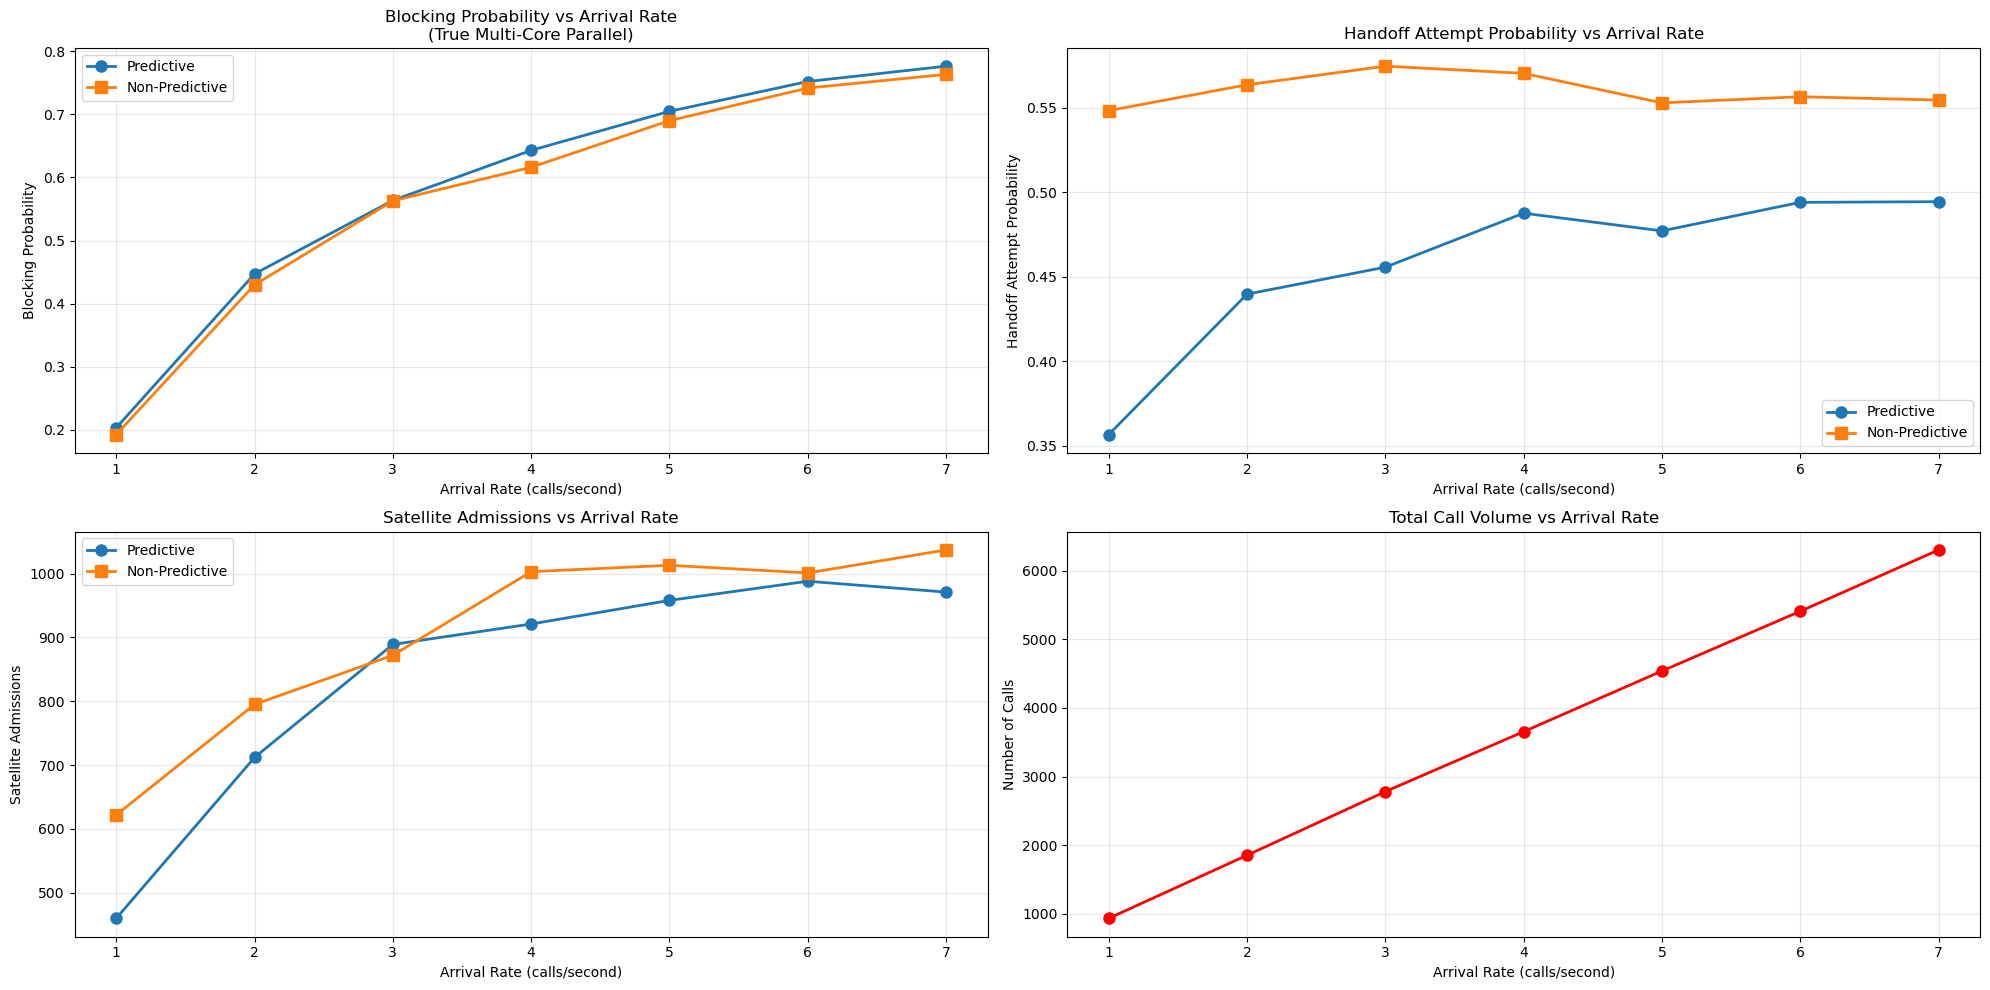

In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the parallel results
with open('arrival_rate_resultsGroup.pkl', 'rb') as f:
    results = pickle.load(f)

# Convert to DataFrame
df_results = pd.DataFrame(results)

print("📊 Parallel Simulation Results:")
print(df_results[['arrival_rate_per_second', 'predictive_blocking_prob', 'nonpredictive_blocking_prob']])

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# 1. Blocking Probability
axes[0,0].plot(df_results['arrival_rate_per_second'], df_results['predictive_blocking_prob'], 
               'o-', label='Predictive', linewidth=2, markersize=8)
axes[0,0].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_blocking_prob'], 
               's-', label='Non-Predictive', linewidth=2, markersize=8)
axes[0,0].set_xlabel('Arrival Rate (calls/second)')
axes[0,0].set_ylabel('Blocking Probability')
axes[0,0].set_title('Blocking Probability vs Arrival Rate\n(True Multi-Core Parallel)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Handoff Attempt Probability
axes[0,1].plot(df_results['arrival_rate_per_second'], df_results['predictive_handoff_attempt_prob'], 
               'o-', label='Predictive', linewidth=2, markersize=8)
axes[0,1].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_handoff_prob_attempt_prob'], 
               's-', label='Non-Predictive', linewidth=2, markersize=8)
axes[0,1].set_xlabel('Arrival Rate (calls/second)')
axes[0,1].set_ylabel('Handoff Attempt Probability')
axes[0,1].set_title('Handoff Attempt Probability vs Arrival Rate')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Satellite Admissions
axes[1,0].plot(df_results['arrival_rate_per_second'], df_results['predictive_calls_admitted_to_satellite'], 
               'o-', label='Predictive', linewidth=2, markersize=8)
axes[1,0].plot(df_results['arrival_rate_per_second'], df_results['nonpredictive_calls_admitted_to_satellite'], 
               's-', label='Non-Predictive', linewidth=2, markersize=8)
axes[1,0].set_xlabel('Arrival Rate (calls/second)')
axes[1,0].set_ylabel('Satellite Admissions')
axes[1,0].set_title('Satellite Admissions vs Arrival Rate')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Total Calls
axes[1,1].plot(df_results['arrival_rate_per_second'], df_results['total_calls'], 
               'o-', label='Total Calls', linewidth=2, markersize=8, color='red')
axes[1,1].set_xlabel('Arrival Rate (calls/second)')
axes[1,1].set_ylabel('Number of Calls')
axes[1,1].set_title('Total Call Volume vs Arrival Rate')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

